In [1]:
!pip install numpy matplotlib

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import asyncio
import torch
import torch.nn as nn
import torch.optim as optim

# פונקציה להדפסת לוחות סודוקו
# הפונקציה מציגה את לוחות הסודוקו בפלט באופן ברור
def print_sudoku(current_board, target_board=None):
    print("\nCurrent Sudoku Board | Target Sudoku Board")
    print("-" * 50)
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("-" * 50)
        current_row = ""
        target_row = ""
        for j in range(9):
            if j % 3 == 0 and j != 0:
                current_row += "| "
                target_row += "| "
            current_row += f"{current_board[i, j] if current_board[i, j] != 0 else '.'} "
            target_row += f"{target_board[i, j] if target_board is not None and target_board[i, j] != 0 else '.'} "
        print(f"{current_row} | {target_row}")
    print("-" * 50)

# פונקציה ליצירת פאזל סודוקו
# הפונקציה הופכת את המחרוזת של התווים ללוח סודוקו.
def generate_puzzle(string):
    return np.array([int(c) for c in string]).reshape((9, 9))

# בדיקת כפילויות
# מטרתה לבדוק את חוקיות הסודוקו, בודקת כל ערך אם הוא מקיים את החוקים
def get_row_col_subgrid(x, y, val, sudoku):
    col = sudoku[:, y].tolist()
    row = sudoku[x].tolist()
    subx, suby = x // 3, y // 3
    subgrid = sudoku[subx * 3:subx * 3 + 3, suby * 3:suby * 3 + 3].flatten().tolist()
    occ_row = row.count(val) - (1 if sudoku[x, y] == val and sudoku[x, y] != 0 else 0)
    occ_col = col.count(val) - (1 if sudoku[x, y] == val and sudoku[x, y] != 0 else 0)
    occ_subgrid = subgrid.count(val) - (1 if sudoku[x, y] == val and sudoku[x, y] != 0 else 0)
    temp = 0
    duplicate_reset = False
    if occ_row == 0: temp += 1
    if occ_col == 0: temp += 1
    if occ_subgrid == 0: temp += 1
    if occ_row > 0 or occ_col > 0 or occ_subgrid > 0:
        duplicate_reset = True
    return temp, duplicate_reset

# יצירת פאזל סודוקו דינמי
# המטרה שלה לייצר לוחות סודוקו פתורים מלאים ואז להסיר מהם מספרים לפי רמת הקושי-קשה,בינוני וקל
def generate_sudoku(difficulty='easy'):
    def solve_sudoku(board):
        empty = [(i, j) for i in range(9) for j in range(9) if board[i, j] == 0]
        if not empty:
            return True
        i, j = empty[0]
        nums = list(range(1, 10))
        random.shuffle(nums)
        for num in nums:
            if get_row_col_subgrid(i, j, num, board)[1] == False:
                board[i, j] = num
                if solve_sudoku(board):
                    return True
                board[i, j] = 0
        return False

    board = np.zeros((9, 9), dtype=int)
    solve_sudoku(board)
    solution = board.copy()
    remove_counts = {'easy': 30, 'medium': 40, 'hard': 50}
    cells_to_remove = remove_counts[difficulty]
    cells = [(i, j) for i in range(9) for j in range(9)]
    random.shuffle(cells)
    for i, j in cells[:cells_to_remove]:
        board[i, j] = 0
    return ''.join(map(str, board.flatten())), ''.join(map(str, solution.flatten()))

# רשת DQN
# יישום DQN
#מטרת המחלקה לקבל את לוח הסודוקו ומחזירה ערכי "קיו" לכל פעולה אפשרית, ערכים אלו מבטים את התועלת הצפויה מכל מהלך שהסוכן יבצע בלוח
class DQN(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dims, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
      #מעבירה את הקלט-הלוח דרך הפונקציה ומוציאה וקטור של ערכי "קיו" כ
        return self.network(x)

# סוכן DQN
#מיישם את הסוכן שלומד לפתור את הלוח בעזרת ערכים ותגמולים של ערכי ה"קיו" כ
class Agent:
    def __init__(self, gamma=0.99, epsilon=1.0, lr=0.001, input_dims=81, n_actions=729, mem_size=50000, batch_size=64, epsilon_end=0.1, epsilon_dec=0.9999):
      #הפונקציה מאתחלת את הסוכן ומגדירה לו את כל הפרמטרים והמשתנים שדרושים לו לתהליך הלמידה, מכינה את הסוכן לפעול בסביבת הסודוקו שלנו
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.epsilon_end = epsilon_end
        self.epsilon_dec = epsilon_dec
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.memory = []
        self.mem_cntr = 0
        self.q_eval = DQN(input_dims, n_actions).to("cpu")
        self.q_target = DQN(input_dims, n_actions).to("cpu")
        self.q_target.load_state_dict(self.q_eval.state_dict())
        self.optimizer = optim.Adam(self.q_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.device = torch.device("cpu")
        self.q_eval.to(self.device)
        self.q_target.to(self.device)
        self.target_update_counter = 0
        self.target_update_freq = 100

    def state_to_tensor(self, state):
      # הופכת כל מצב(לוח סודוקו) לקלט שניתן להשתמש בו ב"די קיו אנ" כ.
        return torch.FloatTensor(state.flatten()).to(self.device).unsqueeze(0)

    def choose_action(self, state, sudoku):
       # מחליטה איזה פעולה יבצע הסוכן שלנו בלוח הסודוקו, כלומר באיזה משבצת להציב כל מספר, משתמשת בשיטת "אפסילון גרידי" שנועדה להבטיח איזון בין חקירה לניצול
        # חקירה הכוונה לבחור פעולה אקראית כדי ללמוד על הסביבה
        #ניצול הכוונה לבחור את הפעולה הטובה ביותר על פי "די קיו אנ" כ
        if random.random() < self.epsilon:
            empty_cells = [(i, j) for i in range(9) for j in range(9) if sudoku[i, j] == 0]
            if empty_cells:
                i, j = random.choice(empty_cells)
                valid_values = self.get_valid_values(i, j, sudoku)
                if valid_values:
                    value = random.choice(valid_values)
                    action = i * 81 + j * 9 + (value - 1)
                    return action
        state_tensor = self.state_to_tensor(state)
        with torch.no_grad():
            q_values = self.q_eval(state_tensor)
        action = q_values.argmax().item()
        x, y = action // 81, (action // 9) % 9
        value = (action % 9) + 1
        if sudoku[x, y] == 0 and self.get_valid_values(x, y, sudoku):
            return action
        return self._random_valid_action(sudoku)

    def _random_valid_action(self, sudoku):
      #  בוחרת פעולה אקראית אחרת תקפה כאשר הפעולה שנבחרה על ידי הרשת אינה תקפה.
        empty_cells = [(i, j) for i in range(9) for j in range(9) if sudoku[i, j] == 0]
        if empty_cells:
            i, j = random.choice(empty_cells)
            valid_values = self.get_valid_values(i, j, sudoku)
            if valid_values:
                value = random.choice(valid_values)
                action = i * 81 + j * 9 + (value - 1)
                return action
        return random.randint(0, self.n_actions - 1)

    def get_valid_values(self, x, y, sudoku):
      #  מחזירה רשימה של ערכים תקפים (1-9) שניתן להציב במשבצת נתונה מבלי להפר את חוקי הסודוקו.
        used = set(sudoku[x]) | set(sudoku[:, y]) | set(sudoku[x//3*3:x//3*3+3, y//3*3:y//3*3+3].flatten())
        return [i for i in range(1, 10) if i not in used and sudoku[x, y] == 0]

    def store_transition(self, state, action, reward, next_state, done):
      #  שומרת מעבר (מצב, פעולה, תגמול, מצב הבא, סיום) בזיכרון הסוכן לשימוש בתהליך הלמידה.
        if len(self.memory) >= self.mem_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
      # מבצעת צעד למידה על ידי דגימת מעברים אקראיים מהזיכרון, חישוב הפסד ועדכון משקלי הרשת.
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states = torch.cat([self.state_to_tensor(state) for state, _, _, _, _ in batch])
        next_states = torch.cat([self.state_to_tensor(next_state) for _, _, _, next_state, _ in batch])
        actions = torch.tensor([action for _, action, _, _, _ in batch], dtype=torch.long).to(self.device)
        rewards = torch.tensor([reward for _, _, reward, _, _ in batch], dtype=torch.float32).to(self.device)
        dones = torch.tensor([done for _, _, _, _, done in batch], dtype=torch.float32).to(self.device)

        q_pred = self.q_eval(states).gather(1, actions.unsqueeze(1))
        with torch.no_grad():
            q_next = self.q_target(next_states).max(1)[0].unsqueeze(1)
            target = rewards + self.gamma * q_next * (1 - dones)

        loss = self.criterion(q_pred, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_dec)
        self.target_update_counter += 1
        if self.target_update_counter % self.target_update_freq == 0:
            self.q_target.load_state_dict(self.q_eval.state_dict())

# סביבת סודוקו
# מגדירה את סביבת הסודוקו כסביבת למידת חיזוקים, כולל לוח, פתרון, מערכת תגמולים, ומעקב אחר פעולות.
class Sudoku:
    def __init__(self, difficulty='easy'):
      # מאתחל את הסביבה שלנו עם פאזל סודוקו ברמת קושי מבין הרמות קושי, לוח פתרון מלא, ומערכת תגמולים שמתאימה לקושי.
        self.difficulty = difficulty
        self.puzzle, self.target = generate_sudoku(difficulty)
        self.sudoku = generate_puzzle(self.puzzle)
        self.target = generate_puzzle(self.target)
        self.filled_positions = set([(i, j) for i in range(9) for j in range(9) if self.sudoku[i, j] != 0])
        self.visited_positions = set()
        self.reward = 0
        self.done = False
        self.rewards_table = {
            'easy': {
                'valid': 20,
                'complete_line': 20,
                'complete_column': 20,
                'complete_block': 20,
                'invalid': -30,
                'repeat': -10,
                'locked': -10,
                'repeat_move': -5,
                'blocked_move': -5,
                'invalid_action': -15,
                'solved': 200,
                'new_move': 5,
                'step': -0.01,
                'reduce_empty': 2,
                'progress': 5,
                'global_inconsistency': -100
            },
            'medium': {
                'valid': 20,
                'complete_line': 15,
                'complete_column': 15,
                'complete_block': 15,
                'invalid': -30,
                'repeat': -12,
                'locked': -12,
                'repeat_move': -6,
                'blocked_move': -6,
                'invalid_action': -18,
                'solved': 200,
                'new_move': 4,
                'step': -0.01,
                'reduce_empty': 1,
                'progress': 4,
                'global_inconsistency': -100
            },
            'hard': {
                'valid': 20,
                'complete_line': 10,
                'complete_column': 10,
                'complete_block': 10,
                'invalid': -30,
                'repeat': -15,
                'locked': -15,
                'repeat_move': -8,
                'blocked_move': -8,
                'invalid_action': -20,
                'solved': 200,
                'new_move': 3,
                'step': -0.01,
                'reduce_empty': 1,
                'progress': 3,
                'global_inconsistency': -100
            }
        }

    def step(self, action, steps, action_history=None):
      #  מבצעת פעולה בסביבה (מילוי משבצת בערך), מחשבת תגמול בהתאם למערכת התגמולים, מעדכנת את הלוח, ובודקת אם המשחק הסתיים.
        if action_history is None:
            action_history = []
        x = action // 81
        y = (action // 9) % 9
        value = (action % 9) + 1
        reward = self.rewards_table[self.difficulty]['step']
        done = False

        if (x, y) in self.filled_positions or (x, y) in self.visited_positions:
            reward += self.rewards_table[self.difficulty]['locked']
            print(f"Debug: Locked position at ({x}, {y}), Reward adjusted by {self.rewards_table[self.difficulty]['locked']}")
            return self.sudoku.copy(), reward, done, action_history

        if self.sudoku[x, y] != 0:
            reward += self.rewards_table[self.difficulty]['repeat']
            print(f"Debug: Repeated position at ({x}, {y}), Reward adjusted by {self.rewards_table[self.difficulty]['repeat']}")
            return self.sudoku.copy(), reward, done, action_history

        temp, duplicate = get_row_col_subgrid(x, y, value, self.sudoku)
        if duplicate:
            reward += self.rewards_table[self.difficulty]['invalid']
            print(f"Debug: Invalid move at ({x}, {y}) with value {value}, Reward adjusted by {self.rewards_table[self.difficulty]['invalid']}")
            return self.sudoku.copy(), reward, done, action_history

        empty_before = np.sum(self.sudoku == 0)
        self.sudoku[x, y] = value
        empty_after = np.sum(self.sudoku == 0)
        self.visited_positions.add((x, y))
        action_history.append((x, y, value))
        reward += self.rewards_table[self.difficulty]['valid']
        reward += self.rewards_table[self.difficulty]['new_move']
        if empty_before > empty_after:
            reward += self.rewards_table[self.difficulty]['reduce_empty']

        if np.all(self.sudoku[x, :] != 0):
            reward += self.rewards_table[self.difficulty]['complete_line']
        if np.all(self.sudoku[:, y] != 0):
            reward += self.rewards_table[self.difficulty]['complete_column']
        subx, suby = x // 3, y // 3
        if np.all(self.sudoku[subx * 3:subx * 3 + 3, suby * 3:suby * 3 + 3] != 0):
            reward += self.rewards_table[self.difficulty]['complete_block']

        mask_empty = (self.sudoku == 0)
        correct_filled = np.sum((self.sudoku == self.target) & ~mask_empty)
        total_to_fill = np.sum(mask_empty)
        if total_to_fill > 0 and correct_filled / (81 - total_to_fill) > 0.9:
            reward += self.rewards_table[self.difficulty]['progress']

        if np.array_equal(self.sudoku, self.target) or np.sum(self.sudoku == 0) == 0:
            reward += self.rewards_table[self.difficulty]['solved']
            done = True
            print("\nSudoku Solved! Episode completed successfully.")
            print(f"Debug: done set to True at step {steps} for difficulty {self.difficulty}")
        else:
            # בדיקה של עקביות
            if not self.is_valid_board(x, y, value):
                reward += self.rewards_table[self.difficulty]['global_inconsistency']
                print(f"Debug: Global inconsistency detected at ({x}, {y}), Reward adjusted by {self.rewards_table[self.difficulty]['global_inconsistency']}")

        return self.sudoku.copy(), reward, done, action_history

    def is_valid_board(self, x, y, value):
      # בודקת אם הצבת ערך במשבצת שומרת על תקינות הלוח מבחינת חוקי הסודוקו (ללא כפילויות).
        temp_board = self.sudoku.copy()
        temp_board[x, y] = 0
        _, duplicate = get_row_col_subgrid(x, y, value, temp_board)
        return not duplicate

    def reset(self):
      #  מאפסת את הסביבה ללוח ההתחלתי של הפאזל, מאתחלת מחדש את המשתנים כמו תגמול ומשבצות שבוקרו.
        self.sudoku = generate_puzzle(self.puzzle)
        self.visited_positions = set()
        self.reward = 0
        self.done = False
        return self.sudoku.copy()


--- Starting Episode 1 (easy) at Mon Jun  9 18:31:06 2025 ---

Initial Board:

Current Sudoku Board | Target Sudoku Board
--------------------------------------------------
3 7 8 | 6 . 9 | 4 . .  | 3 7 8 | 6 2 9 | 4 1 5 
2 . 4 | . 3 5 | 9 6 8  | 2 1 4 | 7 3 5 | 9 6 8 
. . 5 | 1 4 8 | . . .  | 9 6 5 | 1 4 8 | 3 7 2 
--------------------------------------------------
. 4 3 | . 6 2 | 8 9 7  | 1 4 3 | 5 6 2 | 8 9 7 
. 9 . | . . . | 6 5 1  | 7 9 2 | 3 8 4 | 6 5 1 
8 . 6 | 9 7 1 | . . 3  | 8 5 6 | 9 7 1 | 2 4 3 
--------------------------------------------------
4 3 . | 2 . 7 | 5 . .  | 4 3 9 | 2 1 7 | 5 8 6 
5 . 7 | 8 . 6 | . . 4  | 5 2 7 | 8 9 6 | 1 3 4 
. 8 . | 4 5 3 | 7 2 9  | 6 8 1 | 4 5 3 | 7 2 9 
--------------------------------------------------

Step 1: Action=(3, 3, 5), Reward=31.99

Current Sudoku Board | Target Sudoku Board
--------------------------------------------------
3 7 8 | 6 . 9 | 4 . .  | 3 7 8 | 6 2 9 | 4 1 5 
2 . 4 | . 3 5 | 9 6 8  | 2 1 4 | 7 3 5 | 9 6 8 
. . 5 | 1 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
--------------------------------------------------
. 7 6 | 4 3 5 | 8 2 9  | 1 7 6 | 4 3 5 | 8 2 9 
5 8 3 | 7 . 2 | 4 6 1  | 5 8 3 | 7 9 2 | 4 6 1 
4 9 . | 1 8 6 | 7 3 5  | 2 4 9 | 1 8 6 | 7 3 5 
--------------------------------------------------
Debug: Locked position at (3, 4), Reward adjusted by -12

Step 173: Action=(3, 4, 6), Reward=-12.01

Current Sudoku Board | Target Sudoku Board
--------------------------------------------------
3 . 8 | 2 6 7 | 1 5 4  | 3 9 8 | 2 6 7 | 1 5 4 
7 . 4 | 5 1 9 | 2 8 6  | 7 5 4 | 9 1 3 | 2 8 6 
9 1 2 | . 4 8 | 3 . 7  | 6 1 2 | 5 4 8 | 3 9 7 
--------------------------------------------------
8 3 7 | 6 5 1 | 9 . 2  | 8 3 7 | 6 5 1 | 9 4 2 
. 6 9 | 3 2 4 | 5 7 8  | 9 6 1 | 3 2 4 | 5 7 8 
1 2 5 | 8 9 . | 6 4 3  | 4 2 5 | 8 7 9 | 6 1 3 
--------------------------------------------------
. 7 6 | 4 3 5 | 8 2 9  | 1 7 6 | 4 3 5 | 8 2 9 
5 8 3 | 7 . 2 | 4 6 1  | 5 8 3 | 7 9 2 | 4 6 1 
4 9 . | 1 8 6 | 7 3 5 

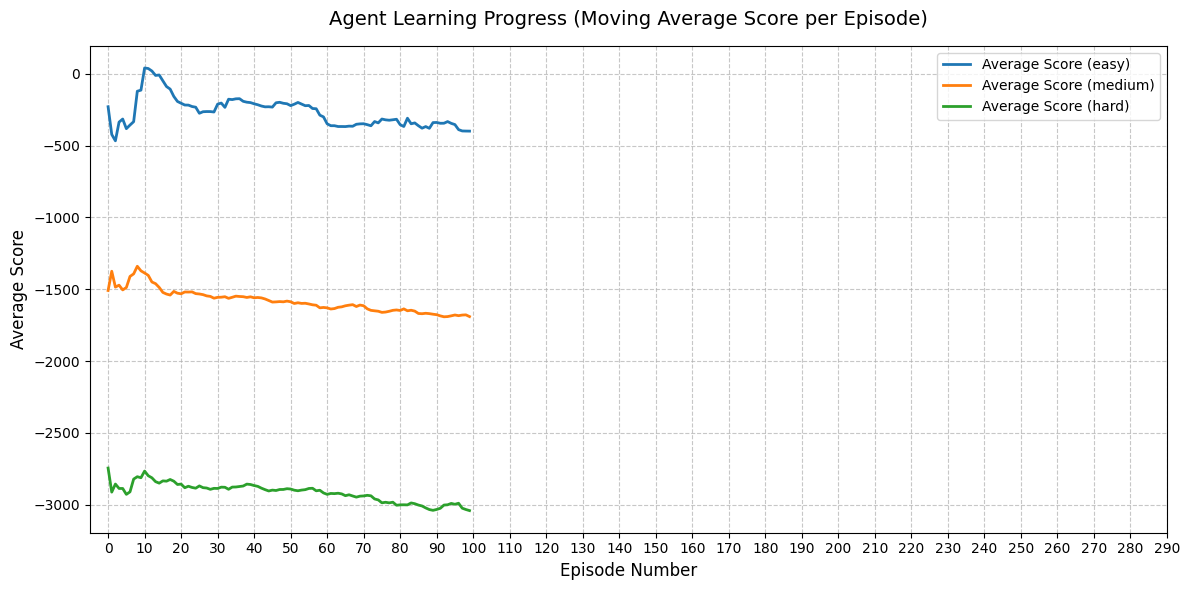

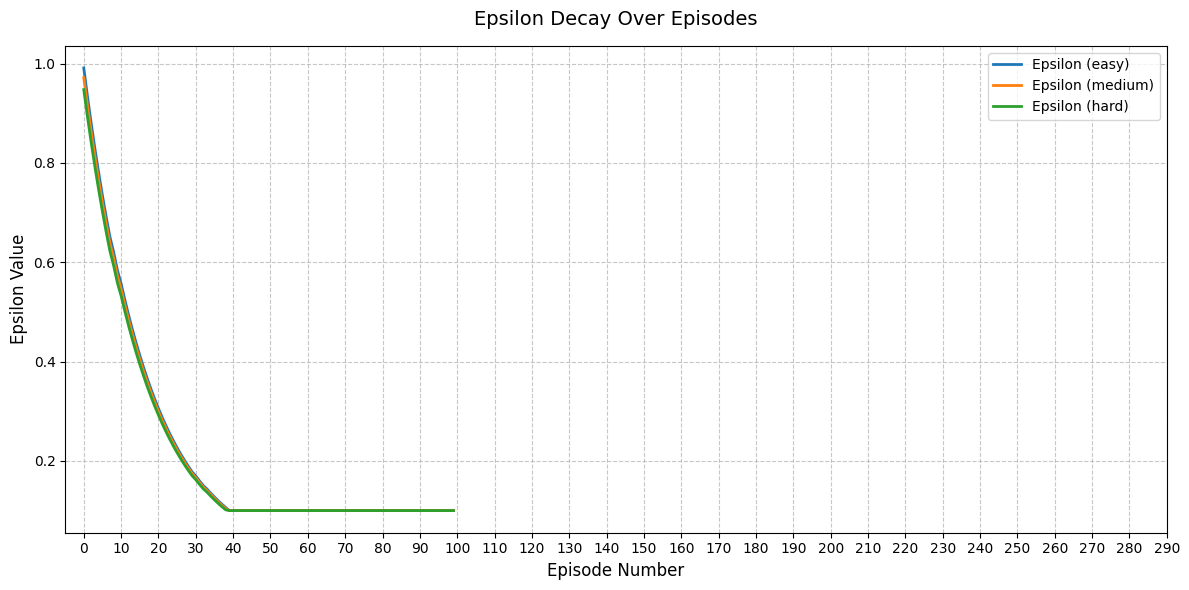

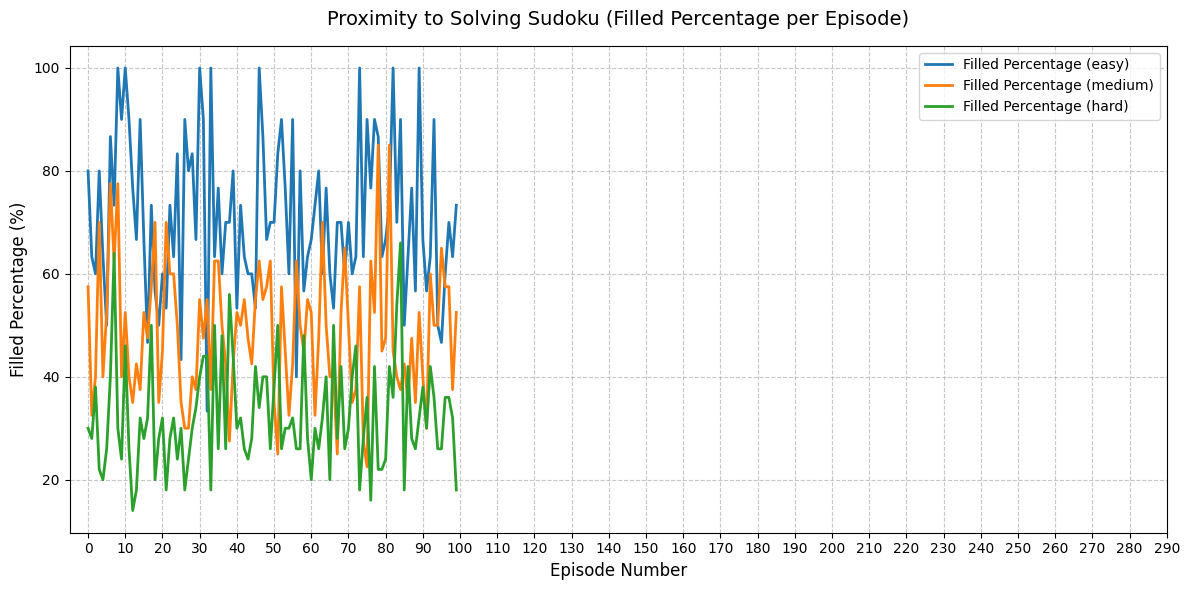

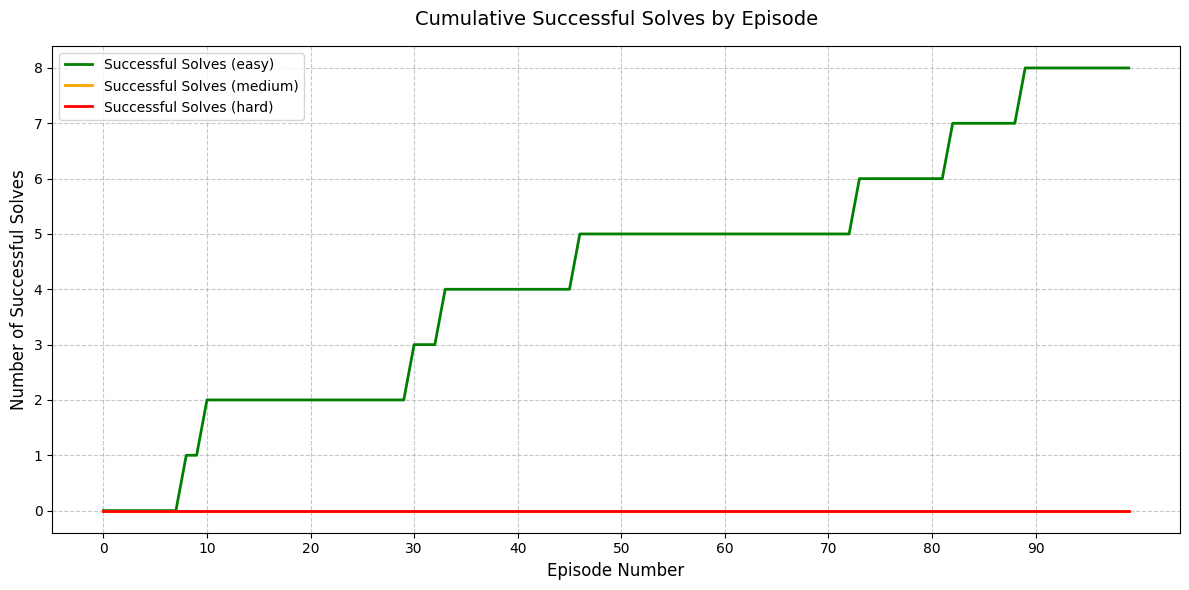


Total runtime: 416.27 seconds


In [3]:
import time

async def main():
  #עוקבת אחר התקדמות הלמידה, שומרת נתונים כמו תגמולים ואחוזי מילוי, ומציגה גרפים של התוצאות של הסוכן על פני מספר אפיזודות בכל הרמות קושי
    FPS = 1000  #קביעת קצב הביצוע של שלבי האימון של הסוכן
    difficulties = ['easy', 'medium', 'hard']
    lr = 0.001
    n_games = 100
    max_steps = {'easy': 150, 'medium': 200, 'hard': 250}
    scores_all = {diff: [] for diff in difficulties}
    eps_history = {diff: [] for diff in difficulties}
    steps_per_episode = {diff: [] for diff in difficulties}
    filled_percentages = {diff: [] for diff in difficulties}
    successful_solves = {diff: [] for diff in difficulties}
    reward_history = {diff: [] for diff in difficulties}

    agent = Agent(gamma=0.99, epsilon=1.0, lr=lr, input_dims=81, n_actions=729, mem_size=50000, batch_size=64, epsilon_end=0.1, epsilon_dec=0.9999)

    total_start_time = time.time()
    for i in range(n_games):
        for diff in difficulties:
            print(f"\n--- Starting Episode {i+1} ({diff}) at {time.ctime()} ---")
            env = Sudoku(difficulty=diff)
            initial_board = env.sudoku.copy()
            print("\nInitial Board:")
            print_sudoku(initial_board, env.target)
            observation = initial_board.copy()
            done = False
            score = 0
            steps = 0
            episode_rewards = []
            action_history = []

            episode_start_time = time.time()
            while not done and steps < max_steps[diff]:
                action = agent.choose_action(observation, env.sudoku)
                x = action // 81
                y = (action // 9) % 9
                value = (action % 9) + 1
                observation_, reward, done, action_history = env.step(action, steps, action_history)
                episode_rewards.append(reward)
                print(f"\nStep {steps+1}: Action=({x}, {y}, {value}), Reward={reward:.2f}")
                print_sudoku(observation_, env.target)
                score += reward
                agent.store_transition(observation, action, reward, observation_, done)
                agent.learn()
                observation = observation_
                steps += 1
                await asyncio.sleep(1.0 / FPS)  # עיכוב קצר
                if time.time() - episode_start_time > 30:  # הגבלת 30 שניות לאפיזודה
                    print(f"\nWarning: Episode {i+1} ({diff}) exceeded 30 seconds, terminating early.")
                    break
                if done:
                    print(f"\nDebug: Episode {i+1} ({diff}) marked as done at step {steps}")

            final_board = env.sudoku
            solution = env.target
            mask_empty = (initial_board == 0)
            total_empty = np.sum(mask_empty)
            correct_filled = np.sum((final_board == solution) & mask_empty)
            filled_percent = 100 * correct_filled / total_empty if total_empty > 0 else 0
            filled_percentages[diff].append(filled_percent)
            steps_per_episode[diff].append(steps)
            scores_all[diff].append(score)
            eps_history[diff].append(agent.epsilon)
            successful_solves[diff].append(1 if filled_percent == 100 else 0)
            reward_history[diff].append(episode_rewards)
            print(f"\nScore: {score:.2f}, Epsilon: {agent.epsilon:.2f}, Filled Percent: {filled_percent:.2f}%, Steps: {steps}")
            print(f"--- Ended Episode {i+1} ({diff}) at {time.ctime()} ---")
            if done:
                print("Episode ended due to successful completion.")
            elif steps >= max_steps[diff]:
                print(f"Episode ended due to {max_steps[diff]}-step limit reached.")
            else:
                print("Episode ended due to time limit or other interruption.")

    # חישוב טווח השלבים עם סקור שלילי בלבד
    range_difficulty_steps = {diff: {'min': float('inf'), 'max': 0} for diff in difficulties}
    threshold_episodes = 0.5
    for diff in difficulties:
        valid_episodes = 0
        for episode_rewards in reward_history[diff]:
            all_negative = True
            start_step = -1
            end_step = -1
            for step, reward in enumerate(episode_rewards):
                if reward > 0:
                    all_negative = False
                    break
                if start_step == -1:
                    start_step = step
                end_step = step
            if all_negative and start_step != -1 and end_step != -1:
                valid_episodes += 1
                range_difficulty_steps[diff]['min'] = min(range_difficulty_steps[diff]['min'], start_step)
                range_difficulty_steps[diff]['max'] = max(range_difficulty_steps[diff]['max'], end_step)
        if valid_episodes / n_games < threshold_episodes:
            range_difficulty_steps[diff]['min'] = 0
            range_difficulty_steps[diff]['max'] = 0

    # גרפים
    window_size = 50
    moving_avg_scores = {diff: [] for diff in difficulties}
    for diff in difficulties:
        for i in range(len(scores_all[diff])):
            start_idx = max(0, i - window_size + 1)
            window = scores_all[diff][start_idx:i + 1]
            moving_avg_scores[diff].append(np.mean(window) if window else 0)

    plt.figure(figsize=(12, 6))
    for diff in difficulties:
        plt.plot(moving_avg_scores[diff], label=f'Average Score ({diff})', linewidth=2)
    plt.title('Agent Learning Progress (Moving Average Score per Episode)', fontsize=14, pad=15)
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Average Score', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, n_games * len(difficulties), 10), fontsize=10)  # התאמה ל-150 אפיזודות לכל רמה
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for diff in difficulties:
        plt.plot(eps_history[diff], label=f'Epsilon ({diff})', linewidth=2)
    plt.title('Epsilon Decay Over Episodes', fontsize=14, pad=15)
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Epsilon Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, n_games * len(difficulties), 10), fontsize=10)  # הצגת כל 150 האפיזודות לכל רמה
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for diff in difficulties:
        plt.plot(filled_percentages[diff], label=f'Filled Percentage ({diff})', linewidth=2)
    plt.title('Proximity to Solving Sudoku (Filled Percentage per Episode)', fontsize=14, pad=15)
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Filled Percentage (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, n_games * len(difficulties), 10), fontsize=10)  # הצגת כל 150 האפיזודות לכל רמה
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for diff, color in zip(difficulties, ['green', 'orange', 'red']):
        cumulative_solves = np.cumsum(successful_solves[diff])
        plt.plot(range(n_games), cumulative_solves, label=f'Successful Solves ({diff})', color=color, linewidth=2)
    plt.title('Cumulative Successful Solves by Episode', fontsize=14, pad=15)
    plt.xlabel('Episode Number', fontsize=12)
    plt.ylabel('Number of Successful Solves', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, n_games, 10), fontsize=10)  # הצגת כל 150 האפיזודות
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\nTotal runtime: {time.time() - total_start_time:.2f} seconds")

# הרץ את התוכנית ישירות בתא
await main()